## Unified interface for your recommender system

Handles:

User-to-movie recommendations (User CF / Item CF / LightFM / Popularity fallback)

Movie-to-movie recommendations (using LightFM embeddings)

Supports interactive input for both types of queries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from lightfm import LightFM
from lightfm.data import Dataset as LightFMDataset
import sys

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

from src.cf_engines import predict_ratings_user_cf, predict_ratings_item_cf

PROCESSED_DIR = "../data/processed"
ratings_file = os.path.join(PROCESSED_DIR, "ratings_processed.csv")
movies_file = os.path.join(PROCESSED_DIR, "movies_processed.csv")
sparse_file = os.path.join(PROCESSED_DIR, "user_item_matrix.pkl")


/Volumes/Crucial X6/Preferee/.venv/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
# Movies
movies = pd.read_csv(movies_file)

# Sparse matrix
with open(sparse_file, "rb") as f:
    user_item_matrix = pickle.load(f)

# User similarity matrix for User CF
user_sim_matrix = cosine_similarity(user_item_matrix)


In [3]:
ratings = pd.read_csv(ratings_file)

lfm_dataset = LightFMDataset()
lfm_dataset.fit(
    users=ratings['user_idx'].unique(),
    items=ratings['movie_idx'].unique()
)

(interactions, _) = lfm_dataset.build_interactions(
    [(row.user_idx, row.movie_idx, row.rating) for row in ratings.itertuples()]
)

lfm_model = LightFM(loss='warp', random_state=42)
lfm_model.fit(interactions, epochs=30, num_threads=4)

# Item embeddings for movie-to-movie recommendations
item_embeddings = lfm_model.get_item_representations()[1]


# Movie-to-Movie Recommendation Function

In [4]:
def recommend_similar_movies(movie_name, movies_df, item_embeddings, top_n=5):
    movie_row = movies_df[movies_df["title"].str.lower() == movie_name.lower()]
    if movie_row.empty:
        print("Movie not found!")
        return None
    
    movie_idx = movie_row.iloc[0]["movie_idx"]
    sim_scores = cosine_similarity([item_embeddings[movie_idx]], item_embeddings)[0]
    similar_idx = np.argsort(-sim_scores)
    similar_idx = similar_idx[similar_idx != movie_idx][:top_n]
    
    return movies_df[movies_df["movie_idx"].isin(similar_idx)][["movie_idx", "title"]]


# User-to-Movie Hybrid Recommendation Function

In [5]:
def recommend_movies_hybrid(user_idx, top_n=10, k=5, min_rated_user=5, min_rated_item=2):
    user_rated_count = user_item_matrix[user_idx].getnnz()
    
    if user_rated_count >= min_rated_user:
        print(f"User CF for user {user_idx}")
        return predict_ratings_user_cf(user_idx, user_item_matrix, user_sim_matrix, movies, top_n, k)
    elif user_rated_count >= min_rated_item:
        print(f"Item CF for user {user_idx}")
        item_sim_matrix = cosine_similarity(user_item_matrix.T)
        return predict_ratings_item_cf(user_idx, user_item_matrix, item_sim_matrix, movies, top_n, k)
    else:
        print(f"LightFM for cold-start user {user_idx}")
        # Recommend top-N using LightFM
        n_items = lfm_dataset.interactions_shape()[1]
        scores = lfm_model.predict(user_idx, np.arange(n_items))
        top_items = np.argsort(-scores)[:top_n]
        return movies[movies["movie_idx"].isin(top_items)][["movie_idx", "title"]]


In [6]:
query_type = input("Type 'user' for user recommendation or 'movie' for movie similarity: ").strip().lower()

if query_type == "user":
    user_input = int(input("Enter user ID: "))
    top_n = int(input("Enter number of recommendations: "))
    display(recommend_movies_hybrid(user_input, top_n=top_n, k=5))
    
elif query_type == "movie":
    movie_input = input("Enter movie name: ")
    top_n = int(input("Enter number of similar movies: "))
    display(recommend_similar_movies(movie_input, movies, item_embeddings, top_n=top_n))
    
else:
    print("Invalid query type. Type 'user' or 'movie'.")


Type 'user' for user recommendation or 'movie' for movie similarity:  user
Enter user ID:  45
Enter number of recommendations:  3


User CF for user 45


,movie_idx,title
126,189,"Godfather, The (1972)"
203,247,Back to the Future (1985)
474,355,Trainspotting (1996)


In [8]:
query_type = input("Type 'user' for user recommendation or 'movie' for movie similarity: ").strip().lower()

if query_type == "user":
    user_input = int(input("Enter user ID: "))
    top_n = int(input("Enter number of recommendations: "))
    display(recommend_movies_hybrid(user_input, top_n=top_n, k=5))
    
elif query_type == "movie":
    movie_input = input("Enter movie name: ")
    top_n = int(input("Enter number of similar movies: "))
    display(recommend_similar_movies(movie_input, movies, item_embeddings, top_n=top_n))
    
else:
    print("Invalid query type. Type 'user' or 'movie'.")

Type 'user' for user recommendation or 'movie' for movie similarity:  movie
Enter movie name:  Back to the Future (1985)
Enter number of similar movies:  3


,movie_idx,title
27,471,Apollo 13 (1995)
201,179,Groundhog Day (1993)
422,57,E.T. the Extra-Terrestrial (1982)


In [9]:
#Visualization

import matplotlib.pyplot as plt
import seaborn as sns

def plot_recommendations(recommendations_df, title="Top Recommendations"):
    """
    Plots top-N recommendations as a horizontal bar chart.
    """
    if recommendations_df is None or recommendations_df.empty:
        print("No recommendations to plot.")
        return
    
    # Since we don't have scores in the previous functions, we'll just assign rank-based score
    recommendations_df = recommendations_df.copy()
    recommendations_df["score"] = np.arange(len(recommendations_df), 0, -1)
    
    plt.figure(figsize=(8, max(4, len(recommendations_df) * 0.5)))
    sns.barplot(
        x="score", 
        y="title", 
        data=recommendations_df, 
        palette="Oranges_r"
    )
    plt.xlabel("Recommendation Score (rank)")
    plt.ylabel("Movie Title")
    plt.title(title)
    plt.tight_layout()
    plt.show()


Type 'user' for user recommendation or 'movie' for movie similarity:  movie
Enter movie name:  Groundhog Day (1993)
Enter number of similar movies:  3



Top 3 movies similar to 'Groundhog Day (1993)':


,movie_idx,title
27,471,Apollo 13 (1995)
203,247,Back to the Future (1985)
209,347,Indiana Jones and the Last Crusade (1989)


/var/folders/gw/9hxr5ymd197gmq5xr15gtmd00000gn/T/ipykernel_55842/2828935028.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


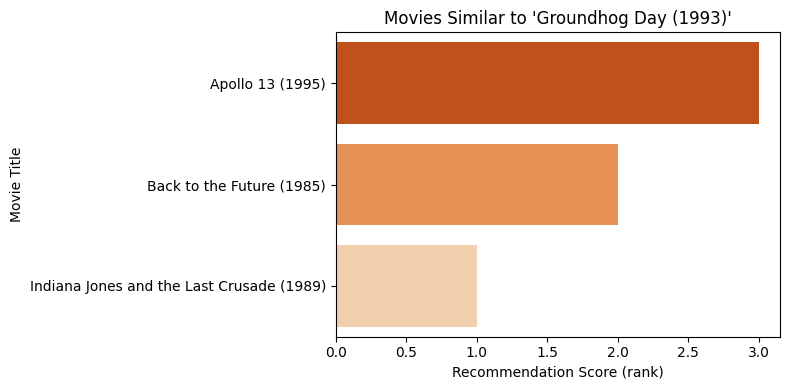

In [10]:
query_type = input("Type 'user' for user recommendation or 'movie' for movie similarity: ").strip().lower()

if query_type == "user":
    user_input = int(input("Enter user ID: "))
    top_n = int(input("Enter number of recommendations: "))
    recs = recommend_movies_hybrid(user_input, top_n=top_n, k=5)
    print(f"\nTop {top_n} recommendations for User {user_input}:")
    display(recs)
    plot_recommendations(recs, title=f"User {user_input} Recommendations")
    
elif query_type == "movie":
    movie_input = input("Enter movie name: ")
    top_n = int(input("Enter number of similar movies: "))
    recs = recommend_similar_movies(movie_input, movies, item_embeddings, top_n=top_n)
    print(f"\nTop {top_n} movies similar to '{movie_input}':")
    display(recs)
    plot_recommendations(recs, title=f"Movies Similar to '{movie_input}'")
    
else:
    print("Invalid query type. Type 'user' or 'movie'.")
